# SVM(支持向量机)
主要的工作是去求解alpha，并找出支持向量，之后去对预测数据分类。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [44]:
# 构建数据
data_mat = np.zeros(shape=(100, 3))
data_mat[:50, 0] = np.linspace(0, 5, 50)
data_mat[50:, 0] = np.linspace(0, 5, 50)
data_mat[:50, 1] = 2*data_mat[:50, 0] + 2
data_mat[50:, 1] = 2*data_mat[50:, 0] - 2
data_mat[:, 1] += np.random.normal(0, 0.5, 100)
data_mat[:, 2] = np.array([1]*50 + [-1]*50)

In [58]:
indice = np.arange(0, 100)
np.random.shuffle(indice)
data_mat = data_mat[indice, :]

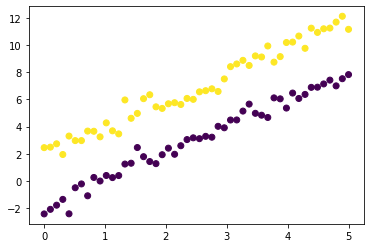

In [59]:
plt.scatter(data_mat[:, 0], data_mat[:, 1], c=data_mat[:, 2])

In [68]:
data = np.loadtxt("data.csv")
dataMat = data[:, :2]
labelMat = data[:, -1]
# dataMat = data_mat[:, :2]
# labelMat = data_mat[:, 2]

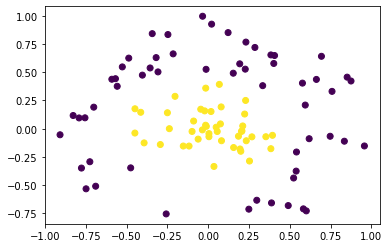

In [69]:
# 数据图
plt.scatter(dataMat[:, 0], dataMat[:, 1], c=labelMat)

In [88]:
class optStruct(object):
    def __init__(self, dataMat, dataLabels, c, threshold):
        self.dataMat = dataMat
        self.dataLabels = dataLabels
        self.sigma = 1.6
        self.c = c
        self.threshold = threshold
        self.row = dataMat.shape[0]
        self.alphas = np.mat(np.zeros(shape=(self.row, 1)))
        self.b = 0
        self.eCache = np.mat(np.zeros(shape=(self.row, 2)))
        self.kernel = np.mat(np.zeros(shape=(self.row, self.row)))
        self.svs = []
        self.labelSV = []
        self.svInd = []
        for i in range(self.row):
            self.kernel[:, i] = kernelTrans(self.dataMat, self.sigma, self.dataMat[i, :])

def kernelTrans(dataMat, sigma, x_i):
    m = dataMat.shape[0]
    tem = np.mat(np.zeros(shape=(dataMat.shape[0], 1)))
    for j in range(m):
        delta = np.mat(dataMat[j, :] - x_i)
        tem[j] = delta*delta.T
    tem = np.exp(tem/(-1*sigma**2))
    return tem

def calcEk(oS, k):
    g_x = np.multiply(oS.alphas, oS.dataLabels).T*oS.kernel[:, k] + oS.b
    e_k = g_x - oS.dataLabels[k]
    return e_k  

def selectJ(i, oS, Ei):
    max_k = -1
    max_deltaE = 0
    Ej = 0
    oS.eCache[i] = [0, Ei]
    validEcacheList = np.nonzero(oS.eCache[:, 0].A)[0]
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ek-Ei)
            if deltaE > max_deltaE:
                max_k = k
                max_deltaE = deltaE
                Ej = Ek
        return max_k, Ej
    else:
        j = i
        while j == i:
            j = int(random.uniform(0, m))
        Ej = calcEk(oS, j)
        return j, Ej

def updateEk(oS, j):
    Ek = calcEk(oS, j)
    oS.eCache[j] = [1, Ek]
    return

def innerL(i, oS):
    Ei = calcEk(oS, i)
    g_x = np.multiply(oS.alphas, oS.dataLabels).T*oS.kernel[:, i] + oS.b
    # 使用SMO算法求解alpha
    if not ((oS.dataLabels[i]*g_x >= 1 and oS.alphas[i] == 0) or (oS.dataLabels[i]*g_x == 1 and 0 < oS.alphas[i] < oS.c) or (oS.dataLabels[i]*g_x <= 1 and oS.alphas[i] == oS.c)): # KKT条件
        # 选择第二参数j的时候，希望Ej-Ei越大越好
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if oS.dataLabels[i] != oS.dataLabels[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.c, c+oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.c)
            H = min(oS.c, oS.alphas[j] + oS.alphas[i])
        if L == H:
            print("L==H")
            return 0
        eta =  oS.kernel[i, i] + oS.kernel[j, j] - 2 * oS.kernel[i, j]
        alphaJnew = alphaJold + oS.dataLabels[j] * (Ei-Ej) / eta
        if alphaJnew > H:
            alphaJnew = H
        elif alphaJnew < L:
            alphaJnew = L
        else:
            alphaJnew = alphaJnew
        oS.alphas[j] = alphaJnew
        updateEk(oS, j)
        if abs(alphaJnew - alphaIold) < oS.threshold:
            print("j not moving enough")
            return 0
        alphaInew = alphaIold + oS.dataLabels[i] * oS.dataLabels[j] * (alphaJold - alphaJnew)
        oS.alphas[i] = alphaInew
        updateEk(oS, i)
        # 求解b
        b1 = b - Ei - oS.dataLabels[i]*(alphaInew - alphaIold)*oS.kernel[i, i] - oS.dataLabels[j]*(alphaJnew - alphaJold)*oS.kernel[j, j]
        b2 = b - Ej - oS.dataLabels[i]*(alphaInew - alphaIold)*oS.kernel[i, j] - oS.dataLabels[j]*(alphaJnew - alphaJold) * oS.kernel[j, j]
        if 0 < alphaInew < oS.c:
            oS.b = b1
        elif 0 < alphaJnew < oS.c:
            oS.b = b2
        else:
            oS.b = (b1+b2) / 2
        # 更新模型的支持向量及标签
        svInd = np.nonzero(oS.alphas)[0]
        oS.svs = oS.dataMat[svInd]
        oS.labelSV = oS.dataLabels[svInd]
        oS.svInd = svInd
        print("thre are %d support vectors" % svs.shape[0])
        return 1
    else:
        return 0

def predict(oS, test_data_mat, test_label_mat):
    m_test = test_data_mat.shape[0]
    errot_count = 0
    # test_kernel = np.mat(np.zeros(shape=(m_test, m_test)))
    for i in range(m_test):
        tem = np.mat(np.zeros(shape=(oS.svs.shape[0], 1)))
        x_i = test_data_mat[i, :]
        for j in range(oS.svs.shape[0]):
            delta = np.mat(oS.svs[j, :] - x_i)
            tem[j] = delta*delta.T
        tem = np.exp(tem/(-1*oS.sigma**2))
        # test_kernel[:, i] = tem
        predict_val = tem.T * np.multiply(oS.labelSV, oS.alphas[oS.svInd]) + oS.b
        if np.sign(predict_val) != np.sign(test_label_mat[i]):
            errot_count += 1
    print("the test error rate is : ", errot_count)
    return

In [89]:
# 计算alpha
c = 200
# 初始化alpha数组
m = dataMat.shape[0]
b = 0
threshold = 0.0001
sigma = 1.6
labelMat = np.mat(labelMat)
dataMat = np.mat(dataMat)
iter = 0
entireset = True
alpha_pair_changed = 0
oS = optStruct(dataMat, labelMat.T, c, threshold)
while (iter < 50 and alpha_pair_changed > 0) or entireset:
    alpha_pair_changed = 0
    if entireset:
        for i in range(m):
            alpha_pair_changed += innerL(i, oS)
        entireset = False
    else:
        nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < c))[0]
        for i in nonBoundIs:
            alpha_pair_changed += innerL(i, oS)
    iter += 1

c:\Users\weitao\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
c:\Users\weitao\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
j not moving enough
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
L==H
L==H
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
L==H
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
j not moving enough
L==H
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
thre are 20 support vectors
j not moving enough
L==H
L==H
thre are 20 support vectors
thre are 20 support vectors
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
L==H
thre are 20 support vectors
L==H
L==H
thre are 20 support vectors
j not moving enough
j not moving enough
j not moving enough
j not moving enough
thre

In [87]:
svInd = np.nonzero(oS.alphas)[0]
svs = oS.dataMat[svInd]
labelSV = oS.dataLabels[svInd]
print("thre are %d support vectors" % svs.shape[0])

thre are 20 support vectors


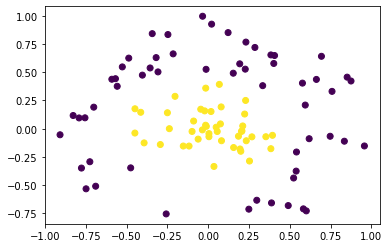

In [73]:
plt.scatter(np.array(oS.dataMat[:, 0]), np.array(oS.dataMat[:, 1]), c=np.array(oS.dataLabels))

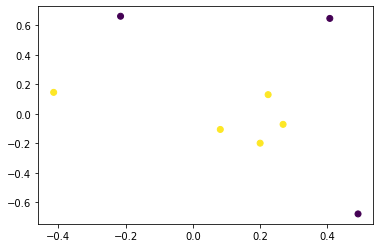

In [74]:
plt.scatter(np.array(svs[:, 0]), np.array(svs[:, 1]), c=np.array(labelSV))

In [90]:
test_data = np.loadtxt("test.csv")
test_data_mat = np.mat(test_data[:, :2])
test_label_mat = np.mat(test_data[:, -1]).T
predict(oS, test_data_mat, test_label_mat)

the test error rate is :  16


In [79]:
test_data = np.loadtxt("test.csv")
test_data_mat = np.mat(test_data[:, :2])
test_label_mat = np.mat(test_data[:, -1]).T
m_test = test_data_mat.shape[0]
errot_count = 0
# test_kernel = np.mat(np.zeros(shape=(m_test, m_test)))
for i in range(m):
    tem = np.mat(np.zeros(shape=(svs.shape[0], 1)))
    x_i = test_data_mat[i, :]
    for j in range(svs.shape[0]):
        delta = np.mat(svs[j, :] - x_i)
        tem[j] = delta*delta.T
    tem = np.exp(tem/(-1*oS.sigma**2))
    # test_kernel[:, i] = tem
    predict = tem.T * np.multiply(labelSV, oS.alphas[svInd]) + oS.b
    if np.sign(predict) != np.sign(test_label_mat[i]):
        errot_count += 1
print("the test error rate is : ", errot_count)

the test error rate is :  9


In [23]:
import pandas as pd
import numpy as np
df = pd.read_csv("data.csv", sep="\s+", header=None)
label = list(df[2])
data = []
for i in range(len(df)):
    data.append(dict(df.iloc[i, :2]))
test_df = pd.read_csv("test.csv", sep="\s+", header=None)
test_label = list(df[2])
test_data = []
for  i in range(len(df)):
    test_data.append(dict(df.iloc[i, :2]))

In [43]:
from libsvm.svmutil import svm_read_problem, svm_problem, svm_train, svm_save_model, svm_parameter, svm_predict
best_score = 0
best_model = None
prob = svm_problem(label, data)
for i in range(-6, 10):
    c = str(np.power(2.0, i))
    for j in range(-6, 3):
        g = str(np.power(2.0, j))
        param = svm_parameter("-s 0 -t 2 -c %s -g %s" % (c, g))
        model = svm_train(prob, param)
        p_label, p_acc, p_val = svm_predict(label, data, model)
        if p_acc[0] > best_score:
            best_model = p_acc
            best_model = model
# print(svm_predict(label, data, model))
# print("p_acc: ", p_acc)

Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 62% (62/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (56/100) (classification)
Accuracy = 56% (

In [44]:
p_label, p_acc, p_val = svm_predict(test_label, test_data, best_model)
print("p_acc: ", p_acc)

Accuracy = 100% (100/100) (classification)
p_acc:  (100.0, 0.0, 1.0)


In [1]:
import pandas as pd
import numpy as np
from libsvm.svmutil import svm_read_problem, svm_problem, svm_train, svm_save_model, svm_parameter, svm_predict

In [56]:
# 读取数据并作预处理
df = pd.read_csv("./krkopt.data", header=None)
df.dropna(inplace=True)
df = df.replace("a", 1.0)
df = df.replace("b", 2.0)
df = df.replace("c", 3.0)
df = df.replace("d", 4.0)
df = df.replace("e", 5.0)
df = df.replace("f", 6.0)
df = df.replace("g", 7.0)
df = df.replace("h", 8.0)
df.loc[df[6] != "draw", 6] = -1
df.loc[df[6] == "draw", 6] = 1
for i in range(6):
    df[i] = (df[i]-df[i].mean()) / df[i].std()
indice = np.arange(0, len(df))
np.random.shuffle(indice)
df = df.iloc[indice, :]
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6
0,-0.116558,1.237021,-0.672625,0.651676,1.287128,0.243815,-1
1,-0.116558,1.237021,-1.107765,-1.538690,0.854279,-0.200949,-1
2,0.950722,0.157590,-0.672625,0.213603,-0.444265,1.578105,-1
3,-1.183838,-0.921841,-0.237484,-1.538690,-0.011417,-1.535239,1
4,-0.116558,0.157590,-1.107765,-1.100617,1.287128,1.133341,-1


In [57]:
def transform_to_libsvm(df):
    test_label = list(df.iloc[:, -1])
    test_data = []
    for  i in range(len(df)):
        test_data.append(dict(df.iloc[i, :-1]))
    return test_label, test_data

def divide_data(df):
    train_precent = 0.4
    valid_precent = 0.1
    train_index = int(len(df)*train_precent)
    valid_index = int(len(df)*(train_precent+valid_precent))
    train_df = df.iloc[:train_index, :]
    valid_df = df.iloc[train_index:valid_index, :]
    test_df = df.iloc[valid_index:, :]
    return train_df, valid_df, test_df

In [58]:
train_df, valid_df, test_df = divide_data(df)

In [59]:
train_label, train_data = transform_to_libsvm(train_df)
valid_label, valid_data = transform_to_libsvm(valid_df)

In [60]:
print(train_label[0], train_data[0])

-1 {0: -0.116557816751179, 1: 1.2370210340291854, 2: -0.6726245071500425, 3: 0.6516761761707407, 4: 1.2871275996144278, 5: 0.24381451432810988}


In [61]:
prob = svm_problem(train_label, train_data)
param = svm_parameter("-s 0 -t 2")
model = svm_train(prob, param)
print(len(model.get_SV()))
p_label, p_acc, p_val = svm_predict(valid_label, valid_data, model)

2252
Accuracy = 97.6479% (2740/2806) (classification)


In [62]:
best_score = 0
best_model = None
prob = svm_problem(train_label, train_data)
for i in range(3, 10):
    c = str(np.power(2.0, i))
    for j in range(0, 3):
        g = str(np.power(2.0, j))
        param = svm_parameter("-s 0 -t 2 -c %s -g %s" % (c, g))
        model = svm_train(prob, param)
        p_label, p_acc, p_val = svm_predict(valid_label, valid_data, model)
        if p_acc[0] > best_score:
            best_score = p_acc[0]
            best_model = model

Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% (2716/2806) (classification)
Accuracy = 99.5367% (2793/2806) (classification)
Accuracy = 99.1803% (2783/2806) (classification)
Accuracy = 96.7926% 

In [63]:
test_label, test_data = transform_to_libsvm(test_df)
p_label, p_acc, p_val = svm_predict(test_label, test_data, model)

Accuracy = 96.7993% (13579/14028) (classification)


In [64]:
print(len(model.get_SV()))

7076


In [53]:
print(best_score)

0
